# First: load imports needed for the project and preparation of the project

In [2]:
# This cell is necessary to use this notebook in google colab
# If you are running this notebook in colab, please change colab to True

import os

colab = True
cwd = os.getcwd()

if colab is True and cwd != "/content/Bsc_Thesis":
  ! git clone https://github.com/SergioTallo/Bsc_Thesis.git
  % cd Bsc_Thesis

print(cwd)

Cloning into 'Bsc_Thesis'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 221 (delta 138), reused 26 (delta 12), pack-reused 0
Receiving objects: 100% (221/221), 3.99 MiB | 5.27 MiB/s, done.
Resolving deltas: 100% (138/138), done.
/content/Bsc_Thesis
/content


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import math
from torch import Tensor, float32, sin, cos
import torch.nn as nn
import matplotlib.pyplot as plt
import utils_bsc
import datetime
import statistics
import seaborn as sns
from tqdm import tqdm

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Device: GPU =', torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('Device: CPU')


Device: GPU = Tesla P100-PCIE-16GB


In [4]:
utils_bsc.print_versions()

versions of packages:
Python: 3.7.13
Pandas: 1.3.5
Numpy: 1.21.6
PyTorch: 1.10.0+cu111
Sklearn: 1.0.2
seaborn: 0.11.2


# Data loading and preparation

Now, we should create a dataset with all the data stored in the .csv file

Description of the data:

*   time: Timestamp (YYYY-MM-DD HH:MM:SS)
*   PLN1: Power in the phase 1 (W)
*   PLN2: Power in the phase 2 (W)
*   PLN3: Power in the phase 3 (W)
*   ULL1: Current Voltage between 2 phases (V)
*   ULL2: Current Voltage between 2 phases (V)
*   ULL3: Current Voltage between 2 phases (V)
*   COS_PHI1: Phase shift (Cos)
*   COS_PHI2: Phase shift (Cos)
*   COS_PHI3: Phase shift (Cos)
*   FREQ: Electricity Frequency (Hz)
*   RC_DC: Fault currents
*   RC_AC: Fault currents
*   RC_50Hz: Fault currents
*   RC_150Hz: Fault currents
*   RC_<100Hz: Fault currents
*   RC_100Hz-1kHz: Fault currents
*   RC_>10kHz: Fault currents


In [7]:
dataset = pd.read_csv('data_factory.csv')
dataset.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,1141.0819,519.5034,482.9381,398.8613,400.1982,395.6010,0.8091,0.6864,0.4875,49.9927,4.0,91.0,10.0,39.0,36.0,86.0,82.0,7.0
1,2020-06-01 00:01:00,1145.1162,519.1807,491.4436,398.6934,400.1579,395.5431,0.8080,0.6903,0.4904,49.9779,5.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
2,2020-06-01 00:02:00,1140.9558,743.3837,484.9942,398.4367,400.1205,395.5259,0.8113,0.9274,0.4806,49.9782,4.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
3,2020-06-01 00:03:00,1151.9409,741.4836,487.4224,398.9800,400.4375,395.8621,0.8249,0.9123,0.4778,49.9850,5.0,66.0,8.0,28.0,25.0,61.0,57.0,2.0
4,2020-06-01 00:04:00,1142.1594,741.9858,486.7629,398.7133,400.3145,395.6446,0.8081,0.9291,0.4552,49.9856,4.0,85.0,11.0,45.0,41.0,75.0,68.0,6.0


Once we have the dataset, we should prepare it. Finding the missing or the NaN values and replace them with suitable values (in this case we use the previous value).

In [8]:
# Replace all mising values with NaN
dataset = dataset.replace(' ', np.nan)
# Search for all the rows with NaN values
nan_values = dataset[dataset.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values before cleaning: {nan_values.shape[0]}') 

# Fill all NaN values with the previous row value
dataset_clean = dataset.fillna(method='ffill')

# Check that there isn't any NaN values
nan_values = dataset_clean[dataset_clean.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values after cleaning: {nan_values.shape[0]}') 

#Total number of samples
print(f'Total number of samples: {dataset_clean.shape[0]}')
print(f'Number of features: {dataset_clean.shape[1]}')

Number of rows with NaN values before cleaning: 2546
Number of rows with NaN values after cleaning: 0
Total number of samples: 63360
Number of features: 19


# Distribution of the data

Now we look at the distribution of the different features of the data over different time intervals.
First we take a look of the min and max values, mean and median value and the standard deviation of every feature.

In [9]:
print_data = False

if print_data is True:
  for column in dataset_clean.columns:
    if column == 'time':
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('')
    else:
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('Mean value: ', dataset_clean[column].mean())
      print('Median value: ', dataset_clean[column].median())
      print('Standard deviation: ', dataset_clean[column].std())
      print('')

In [10]:
# Set to True to print the graphs

print_graphs = False

if print_graphs is True:

  for i, column in enumerate(dataset_clean.columns):
    if i > 0:
      # Feature in a weekly interval
      utils_bsc.week_plot(dataset_clean, i, column)
      # Feature in a daily interval (only the values of weekdays between 4:00 and 19:30)
      utils_bsc.daily_plot(dataset_clean, i, column)

In [8]:
# We print some graphs showing the density distribution of every feature

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_clean.columns):
    if column != 'time':
      sns.displot(dataset_clean, x=column, kind="kde")

After looking to the different data graphs i notice there two very different "time slots" when the data differs. One is Weekdays between 4:00 and 19:30. The other is Weekdays bewteen 19:30 and 4:00 and Weekends.

In [11]:
# We create two extra data sets, one with the weekdays between 4:00 and 18:30 and one with the rest.
dataset_clean_time = pd.to_datetime(dataset_clean['time'])

day_mask = dataset_clean_time.dt.day_name()

time_mask = (dataset_clean_time.dt.hour >= 4) & ((dataset_clean_time.dt.hour < 19) | ((dataset_clean_time.dt.hour == 19) & (dataset_clean_time.dt.minute <= 30))) & ((day_mask == ('Monday')) | (day_mask == ('Tuesday')) | (day_mask == ('Wednesday')) | (day_mask == ('Thursday')) | (day_mask == ('Friday')))

dataset_weekdays = dataset_clean[time_mask]

for i in range(len(time_mask)):
  if time_mask[i] == False:
    time_mask[i] = True
  elif time_mask[i] == True:
    time_mask[i] = False

dataset_weekend = dataset_clean[time_mask]

print(f'Weekdays dataset size: {len(dataset_weekdays)}')
print(f'Weekend dataset size: {len(dataset_weekend)}')

Weekdays dataset size: 29792
Weekend dataset size: 33568


In [12]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays.columns):
    if column != 'time':
      sns.displot(dataset_weekdays, x=column, kind="kde")

In [13]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend.columns):
    if column != 'time':
      sns.displot(dataset_weekend, x=column, kind="kde")

At this time we have three different datasets:

* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)



# Dataset normalisation

The scale of the data of the different features is very dofferent. Its better to have all of the features in the same scale. Therefore we perform a data normalisation. We choose to do a mean/stddev normalisation. We substract from every value the mean value of the feature and divide the result value by the std dev of this specific feature to have feature values with mean 0 and stddev of 1.

In [14]:
# apply the mean / stddev scaling in Pandas using the .mean() and .std() methods
def normalize_mean_std_dataset(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply mean / stddev scaling
    for column in tqdm(df_norm.columns):
      if column != 'time':
        df_norm[column] = (df_norm[column] - df_norm[column].mean()) / df_norm[column].std()
    return df_norm

In [15]:
# Perform the data normalisation in the whole dataset. We can print the distribution of the data if we want.
dataset_norm = normalize_mean_std_dataset(dataset_clean)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_norm.columns):
    if column != 'time':
      sns.displot(dataset_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 895.79it/s]


In [16]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekdays_norm = normalize_mean_std_dataset(dataset_weekdays)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekdays_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1488.09it/s]


In [17]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekend_norm = normalize_mean_std_dataset(dataset_weekend)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekend_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1207.51it/s]


In [18]:
dataset_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,2020-06-01 00:01:00,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,2020-06-01 00:02:00,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,2020-06-01 00:03:00,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,2020-06-01 00:04:00,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [19]:
dataset_weekdays_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
240,2020-06-01 04:00:00,-3.844526,-2.815111,-3.811858,1.679619,1.570822,1.782563,-1.458455,-0.043591,-11.695581,-0.570289,-0.884008,-3.224201,-1.568103,-1.701045,-1.466370,-3.271799,-2.865462,-1.695805
241,2020-06-01 04:01:00,-3.846186,-3.787824,-3.823188,1.763631,1.696076,1.843617,-1.467086,-2.835547,-11.782866,0.903443,2.133621,-3.224201,-1.568103,-1.701045,-1.466370,-3.357651,-2.939190,-1.695805
242,2020-06-01 04:02:00,-3.839272,-1.875102,-2.712874,1.852445,1.730759,1.917486,-1.557711,0.058113,-1.543490,0.445873,0.624807,-1.273229,-0.765503,-1.118658,-0.885575,-1.211362,-0.948518,-0.928865
243,2020-06-01 04:03:00,-3.842709,-3.088604,-3.827000,1.832063,1.744944,1.905749,-1.475716,-0.716154,-12.237347,-0.219683,0.624807,-1.923553,-1.568103,-1.312787,-1.272772,-2.069878,-1.538347,-0.928865
244,2020-06-01 04:04:00,-3.844287,-2.842539,-3.450520,1.753998,1.623568,1.808403,-1.527502,-0.430725,-5.973931,-0.611886,-0.884008,-1.842262,-0.765503,-1.312787,-1.272772,-2.069878,-1.464618,-0.928865


In [20]:
dataset_weekend_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-0.520051,-0.469417,-0.491179,-0.852017,-1.003068,-1.783292,-1.338808,-1.189834,-0.885658,-0.479759,-0.761410,1.276387,1.388355,1.509262,1.555410,1.427389,1.381491,2.307679
1,2020-06-01 00:01:00,-0.518390,-0.469592,-0.485656,-0.905465,-1.016009,-1.803094,-1.356629,-1.159350,-0.870606,-1.233069,0.728477,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
2,2020-06-01 00:02:00,-0.520102,-0.348132,-0.489844,-0.987181,-1.028018,-1.808977,-1.303165,0.693881,-0.921471,-1.217799,-0.761410,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
3,2020-06-01 00:03:00,-0.515582,-0.349161,-0.488267,-0.814230,-0.926227,-1.693993,-1.082826,0.575856,-0.936003,-0.871684,0.728477,-0.211441,0.082473,-0.195407,-0.254028,-0.218005,-0.174360,-0.881879
4,2020-06-01 00:04:00,-0.519607,-0.348889,-0.488696,-0.899130,-0.965723,-1.768380,-1.355009,0.707168,-1.053303,-0.841144,-0.761410,0.919308,2.041296,2.439081,2.377882,0.703416,0.510214,1.669767


At this moment we have six different datasets to use:
* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)
* dataset_norm (Whole dataset, mean/stddev normalised)
* dataset_weekdays_norm (Entries from weekdays from 4:00 to 19:30, mean/stddev normalised)
* dataset_weekend_norm (Entries from Weekends and from weekdays from 19:30 to 4:00, mean/stddev normalised)

Covariance matrix of all features

(63360, 18)
<class 'numpy.float64'>


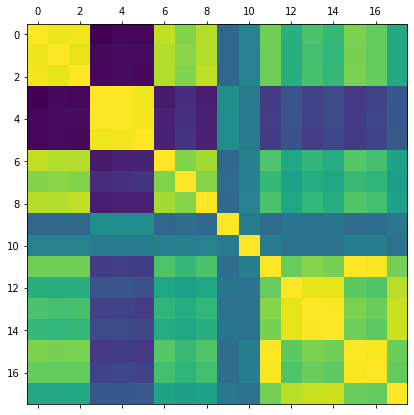

[9.572 2.940 1.352 0.989 0.970 0.891 0.405 0.251 0.230 0.177 0.072 0.052
 0.039 0.031 0.012 0.004 0.004 0.007]
[0.5317647804810274, 0.16335739298653476, 0.07511546472382995, 0.054921627068028424, 0.05390616867076577, 0.04952232661739343, 0.022486349463995598, 0.013932731902136385, 0.012792662672300325, 0.009829012007199104, 0.004024926426955747, 0.002893959610103366, 0.002163271201445878, 0.001741116222641519, 0.0006928432299862775, 0.00021826337426103455, 0.00023351820917083064, 0.0004035851322244031]


In [21]:
import matplotlib.pyplot as plt

set_ = dataset_norm.iloc[:,1:].values

print(set_.shape)
print(type(set_[0][0]))

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cov_matrix = np.cov(set_.T)

fig = plt.figure(figsize=(15, 15))

# Adds subplot on position 1
ax = fig.add_subplot(121)
ax.matshow(cov_matrix)
plt.show()

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

print(eigenvalues)

explained_variance = []

for i in eigenvalues:
    explained_variance.append(i/sum(eigenvalues))

print(explained_variance)

# Correlation between features

In [20]:
correlations = []
matrix = []

for i in dataset_norm.columns[1:]:
  feature = []
  for j in dataset_norm.columns[1:]:
    print(f'Correlation between {i} and {j}')
    correlation = np.corrcoef(dataset_norm[i], dataset_norm[j])
    if i != j:
      correlations.append(abs(correlation[0][1]))
      feature.append(abs(correlation[0][1]))
      print(correlation[0][1])
  print(f'Mean of {i} correlations: {np.mean(feature)}')
  print('')
  matrix.append(feature)

print(f'Mean of all correlations: {np.mean(correlations)}')

Correlation between PLN1 and PLN1
Correlation between PLN1 and PLN2
0.9530638927686161
Correlation between PLN1 and PLN3
0.9606664987977857
Correlation between PLN1 and ULL1
-0.7274016376341783
Correlation between PLN1 and ULL2
-0.6955282277514698
Correlation between PLN1 and ULL3
-0.7030835410050382
Correlation between PLN1 and COS_PHI1
0.8410401295195357
Correlation between PLN1 and COS_PHI2
0.6731338062873107
Correlation between PLN1 and COS_PHI3
0.8122370309192153
Correlation between PLN1 and FREQ
-0.1545159794969928
Correlation between PLN1 and RC_DC
0.041447902380906114
Correlation between PLN1 and RC_AC
0.6311099014117805
Correlation between PLN1 and RC_50Hz
0.3688113546135114
Correlation between PLN1 and RC_150Hz
0.5078743784519385
Correlation between PLN1 and RC_<100Hz
0.4309325330867657
Correlation between PLN1 and RC_100Hz-1kHz
0.6585953463453892
Correlation between PLN1 and RC_>1kHz
0.5928797475823842
Correlation between PLN1 and RC_>10kHz
0.31619183414655355
Mean of PLN1 c

In [21]:
for i in range(len(matrix)):
  print(matrix[i])

[0.9530638927686161, 0.9606664987977857, 0.7274016376341783, 0.6955282277514698, 0.7030835410050382, 0.8410401295195357, 0.6731338062873107, 0.8122370309192153, 0.1545159794969928, 0.041447902380906114, 0.6311099014117805, 0.3688113546135114, 0.5078743784519385, 0.4309325330867657, 0.6585953463453892, 0.5928797475823842, 0.31619183414655355]
[0.9530638927686161, 0.9452605980705139, 0.6920070109902812, 0.6704566233203503, 0.6734582119423186, 0.7986365971843635, 0.7023352006830498, 0.8038123821731546, 0.14213527867385364, 0.039207762733898144, 0.6232451337648502, 0.35899547217519356, 0.4908468912124751, 0.4172313931163452, 0.6488235868701706, 0.5891663952522229, 0.31188438312240335]
[0.9606664987977857, 0.9452605980705139, 0.7002177438968478, 0.6722798995076359, 0.6821156558367119, 0.8022338627218534, 0.6694582338358985, 0.831379706888533, 0.14967487104652202, 0.04088450891644734, 0.6281657734892854, 0.36563522876627164, 0.4989635979541192, 0.423953449978989, 0.653923668551288, 0.5911138

# Preparation Training and Test set

Once the dataset is prepared, make batches of data,put them togheter in an array and split them into train and test sets.
After looking through the dataset and the features, i decided to takeonly the values with a timestap of a weekday between 4:00 and 19:30. In many of the features in the interval outside those timestamps there i only noise, which can be a sign that the machine is off in that time interval.

In [22]:
def create_dataloaders(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one measure (18 features) and target is the next measure (18 features))
  # When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) -1)):
    data = np.array([j for j in dataset_norm.iloc[i, 1:]])
    target = np.array([j for j in dataset_norm.iloc[i+1, 1:]])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1, random_state=25)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the FFN in mini batches

  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_target),
      batch_size=64,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_target),
      batch_size=64,
      shuffle=True
  )

  return loader_train, loader_test

In [23]:
loader_train, loader_test = create_dataloaders(dataset_norm)

100%|██████████| 63359/63359 [00:21<00:00, 2973.61it/s]


length of training set (whole dataset): 57023
length of test set (whole dataset): 6336




In [110]:
def create_sequece_dataloaders(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one sequence of 30 measures (18 features) and target are the next sequence of 30 
  # measures (18 features)). When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - 60)):
    data = np.array(dataset_norm.iloc[i:i+30, 1:])
    target = np.array(dataset_norm.iloc[i+30:i+60, 1:])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1, random_state=25)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the FFN in mini batches

  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_target),
      batch_size=30,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_target),
      batch_size=30,
      shuffle=True
  )

  return loader_train, loader_test, training_data, training_target

In [111]:
loader_train_seq, loader_test_seq, training_data_seq, training_target_seq = create_sequece_dataloaders(dataset_norm)

100%|██████████| 63300/63300 [00:19<00:00, 3187.60it/s]


length of training set (whole dataset): 56970
length of test set (whole dataset): 6330




# Create a Baseline Model

I am taking the Last step as prediction of all features to create a baselinemodel. I will use this baseline model to compare the results of the actual model with it. Everything that works better than this baseline model could be an improvement.

In [32]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train_seq:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test_seq:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

Training set
Mean Loss of baselinemodel:  0.7443867034821714
Standard deviation Loss of baselinemodel:  0.0804365256031089


Test set
Mean Loss of baselinemodel:  0.7505493271407357
Standard deviation Loss of baselinemodel:  0.07856127036060126




# Train a simple Feed Forward Neural Network as a baseline model

I trained a simple FFN Network to have a second baseline model. The final model training should have also a better performance than this FFN.

In [50]:
class ANN_relu(nn.Module):

    def __init__(self, D_in, D_out):
        super(ANN_relu, self).__init__()
        self.linear1 = nn.Linear(D_in, 180)
        self.linear2 = nn.Linear(180, 640)
        self.linear3 = nn.Linear(640, 180)
        self.linear4 = nn.Linear(180, D_out)

        self.relu = torch.nn.ReLU()

        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.relu(x)
        x = self.dropout(x)

        return self.linear4(x)

# This function trains the model for one epoch
def train(model, criterion, optimizer, train_loader, test_loader, n_epochs):

    epoch_loss_train = []
    epoch_loss_test = []

    for e in range(1, n_epochs +1):
      print(f'\nEpoch {e}:')

      print('Train')
      model.train()

      for i in tqdm(train_loader):

        data, target = i[0], i[1]

        optimizer.zero_grad()

        # Forward Pass
        output = model(data)

        #Compute loss
        loss = criterion(output, target)

        #Backpropagation
        loss.backward()

        #Optimization
        optimizer.step()

      losses = []

      print('\nTest with training set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(train_loader):

          data, target = i[0], i[1]

          output = model(data)
              
          losses.append (float(criterion(output, target).item()))

      print('\nCurrent Mean loss Train: ', np.mean(losses))
      epoch_loss_train.append(losses)

      losses = []

      print('\nTest with test set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(test_loader):

          data, target = i[0], i[1]

          output = model(data)
            
          losses.append (float(criterion(output, target).item()))


      print('\nCurrent Mean loss: ', np.mean(losses))
      epoch_loss_test.append(losses)

    return model, epoch_loss_train, epoch_loss_test

In [51]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

Training set
Mean Loss of baselinemodel:  0.4737906602831133
Standard deviation Loss of baselinemodel:  0.0908384682812249


Test set
Mean Loss of baselinemodel:  0.46593057085769346
Standard deviation Loss of baselinemodel:  0.09094930973670025




In [57]:
n_epochs = 200
lr=0.01

# Create model FFN instance
model_FFN_whole = ANN_relu(18, 18).to(device)
print(model_FFN_whole)

# Define Loss
criterion = nn.MSELoss()

# Define Optimizer
optimizer_whole = torch.optim.SGD(model_FFN_whole.parameters(), lr=lr)


train_FFN = True

params_not_trained_whole = model_FFN_whole.parameters()

if train_FFN is True:
  trained_model_FFN_whole , train_losses_whole, test_losses_whole = train(model_FFN_whole, criterion, optimizer_whole, loader_train, loader_test, n_epochs)


ANN_relu(
  (linear1): Linear(in_features=18, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=640, bias=True)
  (linear3): Linear(in_features=640, out_features=180, bias=True)
  (linear4): Linear(in_features=180, out_features=18, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 1:
Train


100%|██████████| 891/891 [00:01<00:00, 475.96it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1078.52it/s]



Current Mean loss Train:  0.45004163791167345

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1092.14it/s]



Current Mean loss:  0.4430994557009803

Epoch 2:
Train


100%|██████████| 891/891 [00:01<00:00, 475.30it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1096.08it/s]



Current Mean loss Train:  0.3736457239363999

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1047.06it/s]



Current Mean loss:  0.366231685937053

Epoch 3:
Train


100%|██████████| 891/891 [00:01<00:00, 477.24it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1087.04it/s]



Current Mean loss Train:  0.34440347948660355

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1143.76it/s]



Current Mean loss:  0.3369331079902071

Epoch 4:
Train


100%|██████████| 891/891 [00:01<00:00, 468.56it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1071.83it/s]



Current Mean loss Train:  0.3296646892388929

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1050.40it/s]



Current Mean loss:  0.3223830031024085

Epoch 5:
Train


100%|██████████| 891/891 [00:01<00:00, 469.48it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1074.09it/s]



Current Mean loss Train:  0.3221313767093333

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1068.56it/s]



Current Mean loss:  0.3148512400761999

Epoch 6:
Train


100%|██████████| 891/891 [00:01<00:00, 468.46it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1091.19it/s]



Current Mean loss Train:  0.31718750935210926

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1111.02it/s]



Current Mean loss:  0.3097767167621189

Epoch 7:
Train


100%|██████████| 891/891 [00:01<00:00, 467.19it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1113.93it/s]



Current Mean loss Train:  0.3133252678328224

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1061.81it/s]



Current Mean loss:  0.3057732932796382

Epoch 8:
Train


100%|██████████| 891/891 [00:01<00:00, 474.01it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1071.99it/s]



Current Mean loss Train:  0.3105640390806327

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1079.00it/s]



Current Mean loss:  0.30307244878224654

Epoch 9:
Train


100%|██████████| 891/891 [00:01<00:00, 472.65it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1094.28it/s]



Current Mean loss Train:  0.3084778987732533

Test with test set


100%|██████████| 99/99 [00:00<00:00, 992.48it/s]



Current Mean loss:  0.3009676614193001

Epoch 10:
Train


100%|██████████| 891/891 [00:01<00:00, 474.87it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1084.99it/s]



Current Mean loss Train:  0.3070360656438853

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1036.65it/s]



Current Mean loss:  0.2994258566336198

Epoch 11:
Train


100%|██████████| 891/891 [00:01<00:00, 468.68it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1083.76it/s]



Current Mean loss Train:  0.3059749840251792

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1088.48it/s]



Current Mean loss:  0.2984726144508882

Epoch 12:
Train


100%|██████████| 891/891 [00:01<00:00, 472.26it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1094.92it/s]



Current Mean loss Train:  0.30494740620405986

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1026.85it/s]



Current Mean loss:  0.29745523300435806

Epoch 13:
Train


100%|██████████| 891/891 [00:01<00:00, 472.95it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1073.50it/s]



Current Mean loss Train:  0.3044918208611935

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1058.52it/s]



Current Mean loss:  0.2969826395162428

Epoch 14:
Train


100%|██████████| 891/891 [00:01<00:00, 473.35it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1095.70it/s]



Current Mean loss Train:  0.30376238160997665

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1125.69it/s]



Current Mean loss:  0.29628653026590446

Epoch 15:
Train


100%|██████████| 891/891 [00:01<00:00, 477.21it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1082.57it/s]



Current Mean loss Train:  0.3033492390555565

Test with test set


100%|██████████| 99/99 [00:00<00:00, 971.48it/s]



Current Mean loss:  0.2957305531911176

Epoch 16:
Train


100%|██████████| 891/891 [00:01<00:00, 471.03it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1087.79it/s]



Current Mean loss Train:  0.3028904181538206

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1057.91it/s]



Current Mean loss:  0.29554422801793223

Epoch 17:
Train


100%|██████████| 891/891 [00:01<00:00, 474.98it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1085.46it/s]



Current Mean loss Train:  0.302519754929976

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1092.12it/s]



Current Mean loss:  0.2952955717390234

Epoch 18:
Train


100%|██████████| 891/891 [00:01<00:00, 470.53it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1081.53it/s]



Current Mean loss Train:  0.3020972908044905

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1041.86it/s]



Current Mean loss:  0.29482707381248474

Epoch 19:
Train


100%|██████████| 891/891 [00:01<00:00, 474.04it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1110.01it/s]



Current Mean loss Train:  0.30173899325323694

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1144.16it/s]



Current Mean loss:  0.2945756943839969

Epoch 20:
Train


100%|██████████| 891/891 [00:01<00:00, 472.26it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1077.79it/s]



Current Mean loss Train:  0.3016893652787246

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1013.69it/s]



Current Mean loss:  0.2945102128115567

Epoch 21:
Train


100%|██████████| 891/891 [00:01<00:00, 475.09it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1072.88it/s]



Current Mean loss Train:  0.30122927379795467

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1092.88it/s]



Current Mean loss:  0.29409857049132837

Epoch 22:
Train


100%|██████████| 891/891 [00:01<00:00, 477.97it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1069.77it/s]



Current Mean loss Train:  0.30074515251398887

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1064.59it/s]



Current Mean loss:  0.29341617136290576

Epoch 23:
Train


100%|██████████| 891/891 [00:01<00:00, 472.52it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1071.89it/s]



Current Mean loss Train:  0.3006811322922391

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1054.41it/s]



Current Mean loss:  0.2934417826960785

Epoch 24:
Train


100%|██████████| 891/891 [00:01<00:00, 477.12it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1079.69it/s]



Current Mean loss Train:  0.3003974325127072

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1064.69it/s]



Current Mean loss:  0.29340827856401

Epoch 25:
Train


100%|██████████| 891/891 [00:01<00:00, 477.84it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1087.51it/s]



Current Mean loss Train:  0.3001041849019418

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1067.29it/s]



Current Mean loss:  0.2929555085873363

Epoch 26:
Train


100%|██████████| 891/891 [00:01<00:00, 476.78it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1099.01it/s]



Current Mean loss Train:  0.29994652462928784

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1071.13it/s]



Current Mean loss:  0.2930155491287058

Epoch 27:
Train


100%|██████████| 891/891 [00:01<00:00, 476.53it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1069.56it/s]



Current Mean loss Train:  0.2996498872802983

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1036.27it/s]



Current Mean loss:  0.2926227180945753

Epoch 28:
Train


100%|██████████| 891/891 [00:01<00:00, 472.51it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1081.24it/s]



Current Mean loss Train:  0.2994718429382669

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1016.69it/s]



Current Mean loss:  0.2923707143224851

Epoch 29:
Train


100%|██████████| 891/891 [00:01<00:00, 468.66it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1076.84it/s]



Current Mean loss Train:  0.2992224073503689

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1090.83it/s]



Current Mean loss:  0.2921082460218006

Epoch 30:
Train


100%|██████████| 891/891 [00:01<00:00, 474.89it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1095.01it/s]



Current Mean loss Train:  0.29918072718027333

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1048.78it/s]



Current Mean loss:  0.29219307667679256

Epoch 31:
Train


100%|██████████| 891/891 [00:01<00:00, 470.31it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1086.41it/s]



Current Mean loss Train:  0.298942300155508

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1091.80it/s]



Current Mean loss:  0.29195455529473047

Epoch 32:
Train


100%|██████████| 891/891 [00:01<00:00, 472.39it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1087.52it/s]



Current Mean loss Train:  0.2986287246013999

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1044.86it/s]



Current Mean loss:  0.29156413930233077

Epoch 33:
Train


100%|██████████| 891/891 [00:01<00:00, 472.37it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1082.47it/s]



Current Mean loss Train:  0.29841659371098284

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1066.28it/s]



Current Mean loss:  0.2913707420982496

Epoch 34:
Train


100%|██████████| 891/891 [00:01<00:00, 474.86it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1087.50it/s]



Current Mean loss Train:  0.2983407773554124

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1028.62it/s]



Current Mean loss:  0.29129238095548415

Epoch 35:
Train


100%|██████████| 891/891 [00:01<00:00, 468.83it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1089.89it/s]



Current Mean loss Train:  0.2982476700837363

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1106.84it/s]



Current Mean loss:  0.29145299123995233

Epoch 36:
Train


100%|██████████| 891/891 [00:01<00:00, 471.42it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1059.29it/s]



Current Mean loss Train:  0.298012581604766

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1120.91it/s]



Current Mean loss:  0.2910194696501048

Epoch 37:
Train


100%|██████████| 891/891 [00:01<00:00, 471.76it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1115.73it/s]



Current Mean loss Train:  0.29803290407933236

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1031.78it/s]



Current Mean loss:  0.29139724599592615

Epoch 38:
Train


100%|██████████| 891/891 [00:01<00:00, 469.12it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1077.41it/s]



Current Mean loss Train:  0.29763458961857153

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1031.56it/s]



Current Mean loss:  0.2908492607600761

Epoch 39:
Train


100%|██████████| 891/891 [00:01<00:00, 471.13it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1088.18it/s]



Current Mean loss Train:  0.2974672536423177

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1053.25it/s]



Current Mean loss:  0.2904751945023585

Epoch 40:
Train


100%|██████████| 891/891 [00:01<00:00, 473.22it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1069.41it/s]



Current Mean loss Train:  0.2975266866812401

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1106.00it/s]



Current Mean loss:  0.2909509282220494

Epoch 41:
Train


100%|██████████| 891/891 [00:01<00:00, 473.72it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1065.10it/s]



Current Mean loss Train:  0.29741362131939725

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1011.01it/s]



Current Mean loss:  0.2905185486030097

Epoch 42:
Train


100%|██████████| 891/891 [00:01<00:00, 471.60it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1047.74it/s]



Current Mean loss Train:  0.2971288086020719

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1020.58it/s]



Current Mean loss:  0.29042857900412394

Epoch 43:
Train


100%|██████████| 891/891 [00:01<00:00, 473.15it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1082.11it/s]



Current Mean loss Train:  0.2970321503887005

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1041.11it/s]



Current Mean loss:  0.2902688983112875

Epoch 44:
Train


100%|██████████| 891/891 [00:01<00:00, 472.46it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1087.21it/s]



Current Mean loss Train:  0.2969637618856933

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1052.88it/s]



Current Mean loss:  0.2902492963605457

Epoch 45:
Train


100%|██████████| 891/891 [00:01<00:00, 475.08it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1057.56it/s]



Current Mean loss Train:  0.29669548077749214

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1094.44it/s]



Current Mean loss:  0.29004758144869947

Epoch 46:
Train


100%|██████████| 891/891 [00:01<00:00, 467.08it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1048.78it/s]



Current Mean loss Train:  0.2967443830604371

Test with test set


100%|██████████| 99/99 [00:00<00:00, 975.86it/s]



Current Mean loss:  0.2901953472332521

Epoch 47:
Train


100%|██████████| 891/891 [00:01<00:00, 473.10it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1099.73it/s]



Current Mean loss Train:  0.29659401338576735

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1075.71it/s]



Current Mean loss:  0.29015157018044985

Epoch 48:
Train


100%|██████████| 891/891 [00:01<00:00, 469.84it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1088.67it/s]



Current Mean loss Train:  0.29644445369206157

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1091.65it/s]



Current Mean loss:  0.28968945837984184

Epoch 49:
Train


100%|██████████| 891/891 [00:01<00:00, 470.07it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1065.64it/s]



Current Mean loss Train:  0.2962310518212324

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1037.23it/s]



Current Mean loss:  0.2896911393512379

Epoch 50:
Train


100%|██████████| 891/891 [00:01<00:00, 472.28it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1059.19it/s]



Current Mean loss Train:  0.2962325604007434

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1064.69it/s]



Current Mean loss:  0.28985630969206494

Epoch 51:
Train


100%|██████████| 891/891 [00:01<00:00, 473.42it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1099.43it/s]



Current Mean loss Train:  0.2961831979211064

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1054.92it/s]



Current Mean loss:  0.2897332759216578

Epoch 52:
Train


100%|██████████| 891/891 [00:01<00:00, 472.13it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1084.10it/s]



Current Mean loss Train:  0.29609991454516194

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1014.59it/s]



Current Mean loss:  0.28977200780252016

Epoch 53:
Train


100%|██████████| 891/891 [00:01<00:00, 470.86it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1071.03it/s]



Current Mean loss Train:  0.2958914468652338

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1015.56it/s]



Current Mean loss:  0.2894768954226465

Epoch 54:
Train


100%|██████████| 891/891 [00:01<00:00, 474.08it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1070.60it/s]



Current Mean loss Train:  0.29582497835426885

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1083.22it/s]



Current Mean loss:  0.28939358107369356

Epoch 55:
Train


100%|██████████| 891/891 [00:01<00:00, 474.88it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1105.43it/s]



Current Mean loss Train:  0.2957369181443545

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1079.56it/s]



Current Mean loss:  0.28921550647778943

Epoch 56:
Train


100%|██████████| 891/891 [00:01<00:00, 476.93it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1085.69it/s]



Current Mean loss Train:  0.29575459015222244

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1041.05it/s]



Current Mean loss:  0.28923204195017765

Epoch 57:
Train


100%|██████████| 891/891 [00:01<00:00, 478.07it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1099.83it/s]



Current Mean loss Train:  0.29554086694479254

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1093.91it/s]



Current Mean loss:  0.2891477933435729

Epoch 58:
Train


100%|██████████| 891/891 [00:01<00:00, 475.96it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1078.88it/s]



Current Mean loss Train:  0.29546926373785193

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1047.64it/s]



Current Mean loss:  0.28909557561079663

Epoch 59:
Train


100%|██████████| 891/891 [00:01<00:00, 468.49it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1097.58it/s]



Current Mean loss Train:  0.29536641826466414

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1084.34it/s]



Current Mean loss:  0.288844610103453

Epoch 60:
Train


100%|██████████| 891/891 [00:01<00:00, 466.47it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1098.31it/s]



Current Mean loss Train:  0.2954265248661758

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1006.26it/s]



Current Mean loss:  0.2891941964626312

Epoch 61:
Train


100%|██████████| 891/891 [00:01<00:00, 462.35it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1091.28it/s]



Current Mean loss Train:  0.29506860394135337

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1030.53it/s]



Current Mean loss:  0.28870196550181415

Epoch 62:
Train


100%|██████████| 891/891 [00:01<00:00, 462.93it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1084.04it/s]



Current Mean loss Train:  0.29504733285986884

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1038.48it/s]



Current Mean loss:  0.28859867035138487

Epoch 63:
Train


100%|██████████| 891/891 [00:01<00:00, 475.47it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1087.96it/s]



Current Mean loss Train:  0.2950002485687618

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1064.41it/s]



Current Mean loss:  0.288529497806472

Epoch 64:
Train


100%|██████████| 891/891 [00:01<00:00, 467.11it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1063.83it/s]



Current Mean loss Train:  0.2948520931129905

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1041.18it/s]



Current Mean loss:  0.28853163439216034

Epoch 65:
Train


100%|██████████| 891/891 [00:01<00:00, 474.38it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1071.21it/s]



Current Mean loss Train:  0.2947371844892149

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1019.47it/s]



Current Mean loss:  0.28835075506658264

Epoch 66:
Train


100%|██████████| 891/891 [00:01<00:00, 471.64it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1089.29it/s]



Current Mean loss Train:  0.29484739068448207

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1041.57it/s]



Current Mean loss:  0.2887654932159366

Epoch 67:
Train


100%|██████████| 891/891 [00:01<00:00, 469.26it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1093.76it/s]



Current Mean loss Train:  0.2946768671976597

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1016.95it/s]



Current Mean loss:  0.2885887543059359

Epoch 68:
Train


100%|██████████| 891/891 [00:01<00:00, 475.51it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1061.12it/s]



Current Mean loss Train:  0.29453611439125305

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1099.15it/s]



Current Mean loss:  0.28840161438542183

Epoch 69:
Train


100%|██████████| 891/891 [00:01<00:00, 474.01it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1079.26it/s]



Current Mean loss Train:  0.29446585605173936

Test with test set


100%|██████████| 99/99 [00:00<00:00, 982.18it/s]



Current Mean loss:  0.2883876959482829

Epoch 70:
Train


100%|██████████| 891/891 [00:01<00:00, 474.15it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1061.49it/s]



Current Mean loss Train:  0.29432615338418083

Test with test set


100%|██████████| 99/99 [00:00<00:00, 973.90it/s]



Current Mean loss:  0.2881000740359528

Epoch 71:
Train


100%|██████████| 891/891 [00:01<00:00, 473.75it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1092.87it/s]



Current Mean loss Train:  0.2943889627987822

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1047.22it/s]



Current Mean loss:  0.28835863747982066

Epoch 72:
Train


100%|██████████| 891/891 [00:01<00:00, 468.70it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1047.55it/s]



Current Mean loss Train:  0.2943099345990972

Test with test set


100%|██████████| 99/99 [00:00<00:00, 976.44it/s]



Current Mean loss:  0.2883497780621654

Epoch 73:
Train


100%|██████████| 891/891 [00:01<00:00, 467.96it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1062.37it/s]



Current Mean loss Train:  0.2940642294190682

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1055.77it/s]



Current Mean loss:  0.2880001435376177

Epoch 74:
Train


100%|██████████| 891/891 [00:01<00:00, 472.04it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1070.97it/s]



Current Mean loss Train:  0.2940124616143947

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1007.38it/s]



Current Mean loss:  0.2878798445065816

Epoch 75:
Train


100%|██████████| 891/891 [00:01<00:00, 475.88it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1066.32it/s]



Current Mean loss Train:  0.29394969210346406

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1003.53it/s]



Current Mean loss:  0.28782639900843304

Epoch 76:
Train


100%|██████████| 891/891 [00:01<00:00, 465.17it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1077.09it/s]



Current Mean loss Train:  0.2938180326177884

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1003.52it/s]



Current Mean loss:  0.28763658305009204

Epoch 77:
Train


100%|██████████| 891/891 [00:01<00:00, 467.78it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1087.92it/s]



Current Mean loss Train:  0.2938108578675524

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1080.07it/s]



Current Mean loss:  0.2877257926897569

Epoch 78:
Train


100%|██████████| 891/891 [00:01<00:00, 471.54it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1056.42it/s]



Current Mean loss Train:  0.29383304066261995

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1018.07it/s]



Current Mean loss:  0.287984789922984

Epoch 79:
Train


100%|██████████| 891/891 [00:01<00:00, 473.48it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1067.32it/s]



Current Mean loss Train:  0.2936983258702806

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1031.91it/s]



Current Mean loss:  0.28769296407699585

Epoch 80:
Train


100%|██████████| 891/891 [00:01<00:00, 476.20it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1054.40it/s]



Current Mean loss Train:  0.29369348690632885

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1000.03it/s]



Current Mean loss:  0.2878227881108872

Epoch 81:
Train


100%|██████████| 891/891 [00:01<00:00, 472.19it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1078.98it/s]



Current Mean loss Train:  0.2934098245720269

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1049.68it/s]



Current Mean loss:  0.2874432412361858

Epoch 82:
Train


100%|██████████| 891/891 [00:01<00:00, 473.10it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1078.89it/s]



Current Mean loss Train:  0.29346833760221935

Test with test set


100%|██████████| 99/99 [00:00<00:00, 998.92it/s]



Current Mean loss:  0.28765776106203444

Epoch 83:
Train


100%|██████████| 891/891 [00:01<00:00, 472.63it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1079.09it/s]



Current Mean loss Train:  0.2933957421552185

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1068.32it/s]



Current Mean loss:  0.28736452005728325

Epoch 84:
Train


100%|██████████| 891/891 [00:01<00:00, 471.35it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1067.75it/s]



Current Mean loss Train:  0.29328747189004817

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1044.19it/s]



Current Mean loss:  0.2872852053907182

Epoch 85:
Train


100%|██████████| 891/891 [00:01<00:00, 467.96it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1101.84it/s]



Current Mean loss Train:  0.29321868185844485

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1077.35it/s]



Current Mean loss:  0.2872230133624992

Epoch 86:
Train


100%|██████████| 891/891 [00:01<00:00, 470.84it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1072.40it/s]



Current Mean loss Train:  0.29306443921979164

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1013.16it/s]



Current Mean loss:  0.28714724050627816

Epoch 87:
Train


100%|██████████| 891/891 [00:01<00:00, 472.82it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1077.33it/s]



Current Mean loss Train:  0.29316468342854385

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1058.77it/s]



Current Mean loss:  0.2873010474323022

Epoch 88:
Train


100%|██████████| 891/891 [00:01<00:00, 468.61it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1060.26it/s]



Current Mean loss Train:  0.2930772772140374

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1055.86it/s]



Current Mean loss:  0.2874086414924776

Epoch 89:
Train


100%|██████████| 891/891 [00:01<00:00, 471.32it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1073.14it/s]



Current Mean loss Train:  0.2928559536450907

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1061.86it/s]



Current Mean loss:  0.28695517642931506

Epoch 90:
Train


100%|██████████| 891/891 [00:01<00:00, 471.46it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1050.05it/s]



Current Mean loss Train:  0.2928695154912544

Test with test set


100%|██████████| 99/99 [00:00<00:00, 998.70it/s]



Current Mean loss:  0.28716909223132664

Epoch 91:
Train


100%|██████████| 891/891 [00:01<00:00, 468.84it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1072.37it/s]



Current Mean loss Train:  0.29281401115769623

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1062.76it/s]



Current Mean loss:  0.2871024190175413

Epoch 92:
Train


100%|██████████| 891/891 [00:01<00:00, 463.19it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1083.78it/s]



Current Mean loss Train:  0.29265160805114054

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1031.35it/s]



Current Mean loss:  0.2867856984487688

Epoch 93:
Train


100%|██████████| 891/891 [00:01<00:00, 463.45it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1073.51it/s]



Current Mean loss Train:  0.2926126267806983

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1069.68it/s]



Current Mean loss:  0.2867526305143279

Epoch 94:
Train


100%|██████████| 891/891 [00:01<00:00, 465.63it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1078.71it/s]



Current Mean loss Train:  0.29268335909755144

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1016.18it/s]



Current Mean loss:  0.2868262320154845

Epoch 95:
Train


100%|██████████| 891/891 [00:01<00:00, 467.83it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1070.46it/s]



Current Mean loss Train:  0.29264850988064284

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1042.26it/s]



Current Mean loss:  0.2870823549802857

Epoch 96:
Train


100%|██████████| 891/891 [00:01<00:00, 469.62it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1073.81it/s]



Current Mean loss Train:  0.29237390843906785

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1097.89it/s]



Current Mean loss:  0.2866671217812432

Epoch 97:
Train


100%|██████████| 891/891 [00:01<00:00, 468.65it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1102.31it/s]



Current Mean loss Train:  0.29253538839276527

Test with test set


100%|██████████| 99/99 [00:00<00:00, 972.10it/s]



Current Mean loss:  0.28705961625985427

Epoch 98:
Train


100%|██████████| 891/891 [00:01<00:00, 465.52it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1072.22it/s]



Current Mean loss Train:  0.2922814868047716

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1004.98it/s]



Current Mean loss:  0.2865708613335484

Epoch 99:
Train


100%|██████████| 891/891 [00:01<00:00, 467.72it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1080.49it/s]



Current Mean loss Train:  0.2922972839589071

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1046.91it/s]



Current Mean loss:  0.2867189772201307

Epoch 100:
Train


100%|██████████| 891/891 [00:01<00:00, 468.06it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1040.83it/s]



Current Mean loss Train:  0.2922872884238743

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1043.81it/s]



Current Mean loss:  0.28679037365046417

Epoch 101:
Train


100%|██████████| 891/891 [00:01<00:00, 455.28it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1062.32it/s]



Current Mean loss Train:  0.29229804242968427

Test with test set


100%|██████████| 99/99 [00:00<00:00, 909.33it/s]



Current Mean loss:  0.286688382878448

Epoch 102:
Train


100%|██████████| 891/891 [00:01<00:00, 461.58it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1051.40it/s]



Current Mean loss Train:  0.2920267675929064

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1027.08it/s]



Current Mean loss:  0.28646617902047705

Epoch 103:
Train


100%|██████████| 891/891 [00:01<00:00, 469.57it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1066.55it/s]



Current Mean loss Train:  0.29202426846246793

Test with test set


100%|██████████| 99/99 [00:00<00:00, 968.63it/s]



Current Mean loss:  0.28653308734147237

Epoch 104:
Train


100%|██████████| 891/891 [00:01<00:00, 463.70it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1058.33it/s]



Current Mean loss Train:  0.2920120601468081

Test with test set


100%|██████████| 99/99 [00:00<00:00, 970.99it/s]



Current Mean loss:  0.286586431692345

Epoch 105:
Train


100%|██████████| 891/891 [00:01<00:00, 463.22it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1039.36it/s]



Current Mean loss Train:  0.2919446785508851

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1039.50it/s]



Current Mean loss:  0.286422358769359

Epoch 106:
Train


100%|██████████| 891/891 [00:01<00:00, 465.21it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1045.72it/s]



Current Mean loss Train:  0.29185548046756404

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1040.76it/s]



Current Mean loss:  0.2863059025822264

Epoch 107:
Train


100%|██████████| 891/891 [00:01<00:00, 470.98it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1060.18it/s]



Current Mean loss Train:  0.29193515212648247

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1011.95it/s]



Current Mean loss:  0.2865508149067561

Epoch 108:
Train


100%|██████████| 891/891 [00:01<00:00, 461.39it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1063.47it/s]



Current Mean loss Train:  0.29169514711724653

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1005.53it/s]



Current Mean loss:  0.2863006329897678

Epoch 109:
Train


100%|██████████| 891/891 [00:01<00:00, 464.88it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1053.20it/s]



Current Mean loss Train:  0.2915861910474555

Test with test set


100%|██████████| 99/99 [00:00<00:00, 946.19it/s]



Current Mean loss:  0.28619779646396637

Epoch 110:
Train


100%|██████████| 891/891 [00:01<00:00, 459.57it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1052.18it/s]



Current Mean loss Train:  0.29166991369825956

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1018.03it/s]



Current Mean loss:  0.28640811070047245

Epoch 111:
Train


100%|██████████| 891/891 [00:01<00:00, 467.08it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1047.21it/s]



Current Mean loss Train:  0.2915043759961455

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1014.08it/s]



Current Mean loss:  0.2862313532769078

Epoch 112:
Train


100%|██████████| 891/891 [00:01<00:00, 464.87it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1056.00it/s]



Current Mean loss Train:  0.2915411790211995

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1042.91it/s]



Current Mean loss:  0.2863098753221107

Epoch 113:
Train


100%|██████████| 891/891 [00:01<00:00, 466.63it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1068.90it/s]



Current Mean loss Train:  0.2916215216337497

Test with test set


100%|██████████| 99/99 [00:00<00:00, 932.87it/s]



Current Mean loss:  0.2865148413963992

Epoch 114:
Train


100%|██████████| 891/891 [00:01<00:00, 464.13it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1071.91it/s]



Current Mean loss Train:  0.2913311116991086

Test with test set


100%|██████████| 99/99 [00:00<00:00, 946.62it/s]



Current Mean loss:  0.28593431413173676

Epoch 115:
Train


100%|██████████| 891/891 [00:01<00:00, 462.40it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1034.38it/s]



Current Mean loss Train:  0.2912672162055969

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1022.43it/s]



Current Mean loss:  0.28594754967424607

Epoch 116:
Train


100%|██████████| 891/891 [00:01<00:00, 461.15it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1046.52it/s]



Current Mean loss Train:  0.2913013898028535

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1006.79it/s]



Current Mean loss:  0.2859630303250419

Epoch 117:
Train


100%|██████████| 891/891 [00:01<00:00, 453.55it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1058.44it/s]



Current Mean loss Train:  0.29127161149625425

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1029.39it/s]



Current Mean loss:  0.2860453192031745

Epoch 118:
Train


100%|██████████| 891/891 [00:01<00:00, 461.10it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1056.29it/s]



Current Mean loss Train:  0.29143656288533903

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1004.99it/s]



Current Mean loss:  0.28576125355079923

Epoch 119:
Train


100%|██████████| 891/891 [00:01<00:00, 462.65it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1064.06it/s]



Current Mean loss Train:  0.29117241904858654

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1020.43it/s]



Current Mean loss:  0.2857093213483541

Epoch 120:
Train


100%|██████████| 891/891 [00:01<00:00, 463.52it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1074.32it/s]



Current Mean loss Train:  0.2910881928522579

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1058.91it/s]



Current Mean loss:  0.2859241483789502

Epoch 121:
Train


100%|██████████| 891/891 [00:01<00:00, 463.27it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1047.84it/s]



Current Mean loss Train:  0.29096075568001145

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1029.31it/s]



Current Mean loss:  0.2858290550383655

Epoch 122:
Train


100%|██████████| 891/891 [00:01<00:00, 466.33it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1056.26it/s]



Current Mean loss Train:  0.29106263781236075

Test with test set


100%|██████████| 99/99 [00:00<00:00, 912.12it/s]



Current Mean loss:  0.28609581923846045

Epoch 123:
Train


100%|██████████| 891/891 [00:01<00:00, 460.28it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1055.74it/s]



Current Mean loss Train:  0.2909835070438524

Test with test set


100%|██████████| 99/99 [00:00<00:00, 995.04it/s]



Current Mean loss:  0.285559753877948

Epoch 124:
Train


100%|██████████| 891/891 [00:01<00:00, 467.29it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1069.06it/s]



Current Mean loss Train:  0.2908462795578403

Test with test set


100%|██████████| 99/99 [00:00<00:00, 991.90it/s]



Current Mean loss:  0.28561412264602354

Epoch 125:
Train


100%|██████████| 891/891 [00:01<00:00, 463.29it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1047.14it/s]



Current Mean loss Train:  0.290802186302732

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1106.51it/s]



Current Mean loss:  0.28568627346645703

Epoch 126:
Train


100%|██████████| 891/891 [00:01<00:00, 464.60it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1058.54it/s]



Current Mean loss Train:  0.2907269963645507

Test with test set


100%|██████████| 99/99 [00:00<00:00, 993.14it/s]



Current Mean loss:  0.2857444199046703

Epoch 127:
Train


100%|██████████| 891/891 [00:01<00:00, 461.02it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1036.33it/s]



Current Mean loss Train:  0.29074541110583024

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1057.20it/s]



Current Mean loss:  0.28557192466475745

Epoch 128:
Train


100%|██████████| 891/891 [00:01<00:00, 461.26it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1054.46it/s]



Current Mean loss Train:  0.2906109004644165

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1030.55it/s]



Current Mean loss:  0.28559639824159216

Epoch 129:
Train


100%|██████████| 891/891 [00:01<00:00, 458.73it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1036.34it/s]



Current Mean loss Train:  0.29050596138644297

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1035.81it/s]



Current Mean loss:  0.2854260192676024

Epoch 130:
Train


100%|██████████| 891/891 [00:01<00:00, 462.32it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1032.98it/s]



Current Mean loss Train:  0.2905879144950882

Test with test set


100%|██████████| 99/99 [00:00<00:00, 925.32it/s]



Current Mean loss:  0.2855336288310061

Epoch 131:
Train


100%|██████████| 891/891 [00:01<00:00, 462.13it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1027.15it/s]



Current Mean loss Train:  0.2904915823345099

Test with test set


100%|██████████| 99/99 [00:00<00:00, 938.53it/s]



Current Mean loss:  0.2855294528934691

Epoch 132:
Train


100%|██████████| 891/891 [00:01<00:00, 450.66it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1050.65it/s]



Current Mean loss Train:  0.2903899814845737

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1046.80it/s]



Current Mean loss:  0.28524262661283667

Epoch 133:
Train


100%|██████████| 891/891 [00:01<00:00, 464.59it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1043.95it/s]



Current Mean loss Train:  0.2904102744578512

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1023.34it/s]



Current Mean loss:  0.2854208183107954

Epoch 134:
Train


100%|██████████| 891/891 [00:01<00:00, 458.93it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1045.40it/s]



Current Mean loss Train:  0.2904318367725805

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1045.08it/s]



Current Mean loss:  0.2856809663953203

Epoch 135:
Train


100%|██████████| 891/891 [00:01<00:00, 458.78it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1054.16it/s]



Current Mean loss Train:  0.29045912171855115

Test with test set


100%|██████████| 99/99 [00:00<00:00, 995.61it/s]



Current Mean loss:  0.2857898711556136

Epoch 136:
Train


100%|██████████| 891/891 [00:01<00:00, 462.52it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1048.14it/s]



Current Mean loss Train:  0.2902409109369539

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1000.10it/s]



Current Mean loss:  0.28515588213699034

Epoch 137:
Train


100%|██████████| 891/891 [00:01<00:00, 462.83it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1050.41it/s]



Current Mean loss Train:  0.29021075495030607

Test with test set


100%|██████████| 99/99 [00:00<00:00, 996.85it/s]



Current Mean loss:  0.28518057757555837

Epoch 138:
Train


100%|██████████| 891/891 [00:01<00:00, 461.15it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1067.21it/s]



Current Mean loss Train:  0.2900820243706473

Test with test set


100%|██████████| 99/99 [00:00<00:00, 926.71it/s]



Current Mean loss:  0.2851506456582233

Epoch 139:
Train


100%|██████████| 891/891 [00:01<00:00, 454.77it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1028.81it/s]



Current Mean loss Train:  0.29050826315593503

Test with test set


100%|██████████| 99/99 [00:00<00:00, 990.72it/s]



Current Mean loss:  0.2860690209299627

Epoch 140:
Train


100%|██████████| 891/891 [00:01<00:00, 460.60it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1062.84it/s]



Current Mean loss Train:  0.2900077950974506

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1018.31it/s]



Current Mean loss:  0.28510805422609503

Epoch 141:
Train


100%|██████████| 891/891 [00:01<00:00, 467.98it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1060.03it/s]



Current Mean loss Train:  0.2899208204312758

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1017.90it/s]



Current Mean loss:  0.28513991080149254

Epoch 142:
Train


100%|██████████| 891/891 [00:01<00:00, 459.07it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1075.25it/s]



Current Mean loss Train:  0.2899033377400686

Test with test set


100%|██████████| 99/99 [00:00<00:00, 990.92it/s]



Current Mean loss:  0.28510095901561505

Epoch 143:
Train


100%|██████████| 891/891 [00:01<00:00, 464.90it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1067.54it/s]



Current Mean loss Train:  0.28986226152691374

Test with test set


100%|██████████| 99/99 [00:00<00:00, 991.40it/s]



Current Mean loss:  0.2850705775046589

Epoch 144:
Train


100%|██████████| 891/891 [00:01<00:00, 463.81it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1043.45it/s]



Current Mean loss Train:  0.28977012232899263

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1013.81it/s]



Current Mean loss:  0.28492850817815224

Epoch 145:
Train


100%|██████████| 891/891 [00:01<00:00, 466.64it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1068.36it/s]



Current Mean loss Train:  0.2897566495385903

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1015.78it/s]



Current Mean loss:  0.28497830996609697

Epoch 146:
Train


100%|██████████| 891/891 [00:01<00:00, 467.85it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1067.59it/s]



Current Mean loss Train:  0.2896981924671918

Test with test set


100%|██████████| 99/99 [00:00<00:00, 912.25it/s]



Current Mean loss:  0.28502821109511634

Epoch 147:
Train


100%|██████████| 891/891 [00:01<00:00, 460.01it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1075.92it/s]



Current Mean loss Train:  0.28962657002755154

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1031.41it/s]



Current Mean loss:  0.2849885408926492

Epoch 148:
Train


100%|██████████| 891/891 [00:01<00:00, 470.17it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1069.70it/s]



Current Mean loss Train:  0.28959597896378986

Test with test set


100%|██████████| 99/99 [00:00<00:00, 995.25it/s]



Current Mean loss:  0.2848780396008732

Epoch 149:
Train


100%|██████████| 891/891 [00:01<00:00, 468.34it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1062.20it/s]



Current Mean loss Train:  0.28959964214083056

Test with test set


100%|██████████| 99/99 [00:00<00:00, 996.09it/s]



Current Mean loss:  0.28492988254686796

Epoch 150:
Train


100%|██████████| 891/891 [00:01<00:00, 470.18it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1058.05it/s]



Current Mean loss Train:  0.28954648222318535

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1042.24it/s]



Current Mean loss:  0.28496513779115196

Epoch 151:
Train


100%|██████████| 891/891 [00:01<00:00, 463.32it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1049.68it/s]



Current Mean loss Train:  0.28978978181059245

Test with test set


100%|██████████| 99/99 [00:00<00:00, 945.51it/s]



Current Mean loss:  0.28541601501932046

Epoch 152:
Train


100%|██████████| 891/891 [00:01<00:00, 473.49it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1075.14it/s]



Current Mean loss Train:  0.28942060417063975

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1028.11it/s]



Current Mean loss:  0.284749247359507

Epoch 153:
Train


100%|██████████| 891/891 [00:01<00:00, 464.65it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1044.46it/s]



Current Mean loss Train:  0.28943148181762224

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1022.54it/s]



Current Mean loss:  0.28491512332299745

Epoch 154:
Train


100%|██████████| 891/891 [00:01<00:00, 466.49it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1070.99it/s]



Current Mean loss Train:  0.28935157853010396

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1033.55it/s]



Current Mean loss:  0.2848268134726418

Epoch 155:
Train


100%|██████████| 891/891 [00:01<00:00, 472.18it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1067.85it/s]



Current Mean loss Train:  0.28939643649407376

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1002.18it/s]



Current Mean loss:  0.28499437462199817

Epoch 156:
Train


100%|██████████| 891/891 [00:01<00:00, 467.76it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1054.03it/s]



Current Mean loss Train:  0.28919005113017276

Test with test set


100%|██████████| 99/99 [00:00<00:00, 970.48it/s]



Current Mean loss:  0.2847503681074489

Epoch 157:
Train


100%|██████████| 891/891 [00:01<00:00, 464.30it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1069.08it/s]



Current Mean loss Train:  0.2892111523952816

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1031.94it/s]



Current Mean loss:  0.2848474079310292

Epoch 158:
Train


100%|██████████| 891/891 [00:01<00:00, 465.03it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1061.28it/s]



Current Mean loss Train:  0.2893094461407057

Test with test set


100%|██████████| 99/99 [00:00<00:00, 989.40it/s]



Current Mean loss:  0.28492970674326923

Epoch 159:
Train


100%|██████████| 891/891 [00:01<00:00, 462.50it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1061.59it/s]



Current Mean loss Train:  0.2891364843154997

Test with test set


100%|██████████| 99/99 [00:00<00:00, 968.33it/s]



Current Mean loss:  0.28473279828375037

Epoch 160:
Train


100%|██████████| 891/891 [00:01<00:00, 463.15it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1066.76it/s]



Current Mean loss Train:  0.2890971418884065

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1010.64it/s]



Current Mean loss:  0.28461977854521586

Epoch 161:
Train


100%|██████████| 891/891 [00:01<00:00, 466.08it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1072.20it/s]



Current Mean loss Train:  0.288983025317374

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1106.10it/s]



Current Mean loss:  0.284430945160413

Epoch 162:
Train


100%|██████████| 891/891 [00:01<00:00, 461.86it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1046.34it/s]



Current Mean loss Train:  0.2889268060458362

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1093.02it/s]



Current Mean loss:  0.2845529022842947

Epoch 163:
Train


100%|██████████| 891/891 [00:01<00:00, 469.95it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1086.13it/s]



Current Mean loss Train:  0.2889221264958783

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1037.60it/s]



Current Mean loss:  0.28458207845687866

Epoch 164:
Train


100%|██████████| 891/891 [00:01<00:00, 471.46it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1072.91it/s]



Current Mean loss Train:  0.28885339740684673

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1036.27it/s]



Current Mean loss:  0.2845230195859466

Epoch 165:
Train


100%|██████████| 891/891 [00:01<00:00, 463.79it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1057.62it/s]



Current Mean loss Train:  0.28888781176405454

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1005.51it/s]



Current Mean loss:  0.28435326164419

Epoch 166:
Train


100%|██████████| 891/891 [00:01<00:00, 468.06it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1071.48it/s]



Current Mean loss Train:  0.28880471223599447

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1012.14it/s]



Current Mean loss:  0.2844830010876511

Epoch 167:
Train


100%|██████████| 891/891 [00:01<00:00, 461.92it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1053.97it/s]



Current Mean loss Train:  0.2887131592507582

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1029.70it/s]



Current Mean loss:  0.28437638749377897

Epoch 168:
Train


100%|██████████| 891/891 [00:01<00:00, 468.27it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1064.12it/s]



Current Mean loss Train:  0.28871017184388625

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1015.74it/s]



Current Mean loss:  0.2844815638029214

Epoch 169:
Train


100%|██████████| 891/891 [00:01<00:00, 456.28it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1043.50it/s]



Current Mean loss Train:  0.28861821659419407

Test with test set


100%|██████████| 99/99 [00:00<00:00, 893.17it/s]



Current Mean loss:  0.28442179389072186

Epoch 170:
Train


100%|██████████| 891/891 [00:01<00:00, 454.59it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1025.71it/s]



Current Mean loss Train:  0.28867365602157197

Test with test set


100%|██████████| 99/99 [00:00<00:00, 924.74it/s]



Current Mean loss:  0.28425538705454934

Epoch 171:
Train


100%|██████████| 891/891 [00:01<00:00, 453.37it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1043.44it/s]



Current Mean loss Train:  0.28862076347189985

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1019.51it/s]



Current Mean loss:  0.2843602087461587

Epoch 172:
Train


100%|██████████| 891/891 [00:01<00:00, 456.36it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1078.58it/s]



Current Mean loss Train:  0.2885825619954453

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1045.62it/s]



Current Mean loss:  0.28446975049346385

Epoch 173:
Train


100%|██████████| 891/891 [00:01<00:00, 458.24it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1068.24it/s]



Current Mean loss Train:  0.28852169608695205

Test with test set


100%|██████████| 99/99 [00:00<00:00, 943.04it/s]



Current Mean loss:  0.2843593855698903

Epoch 174:
Train


100%|██████████| 891/891 [00:01<00:00, 463.63it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1073.94it/s]



Current Mean loss Train:  0.2884400536616643

Test with test set


100%|██████████| 99/99 [00:00<00:00, 970.43it/s]



Current Mean loss:  0.28417862349688405

Epoch 175:
Train


100%|██████████| 891/891 [00:01<00:00, 462.42it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1049.92it/s]



Current Mean loss Train:  0.28853229885684656

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1004.11it/s]



Current Mean loss:  0.28444965274044964

Epoch 176:
Train


100%|██████████| 891/891 [00:01<00:00, 461.48it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1064.28it/s]



Current Mean loss Train:  0.28840397968971904

Test with test set


100%|██████████| 99/99 [00:00<00:00, 890.26it/s]



Current Mean loss:  0.28428000016043886

Epoch 177:
Train


100%|██████████| 891/891 [00:01<00:00, 460.90it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1044.55it/s]



Current Mean loss Train:  0.28843519583294286

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1015.31it/s]



Current Mean loss:  0.28435551036487927

Epoch 178:
Train


100%|██████████| 891/891 [00:01<00:00, 457.32it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1021.94it/s]



Current Mean loss Train:  0.2883288514801415

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1023.10it/s]



Current Mean loss:  0.28411620072644167

Epoch 179:
Train


100%|██████████| 891/891 [00:01<00:00, 458.05it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1041.17it/s]



Current Mean loss Train:  0.2882875431366641

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1015.94it/s]



Current Mean loss:  0.28422934163098384

Epoch 180:
Train


100%|██████████| 891/891 [00:01<00:00, 469.13it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1065.18it/s]



Current Mean loss Train:  0.28831804977723646

Test with test set


100%|██████████| 99/99 [00:00<00:00, 994.57it/s]



Current Mean loss:  0.28433614623064946

Epoch 181:
Train


100%|██████████| 891/891 [00:01<00:00, 465.98it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1054.21it/s]



Current Mean loss Train:  0.2881140783512766

Test with test set


100%|██████████| 99/99 [00:00<00:00, 915.09it/s]



Current Mean loss:  0.2840931052812422

Epoch 182:
Train


100%|██████████| 891/891 [00:01<00:00, 462.34it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1051.59it/s]



Current Mean loss Train:  0.2883353322644025

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1004.84it/s]



Current Mean loss:  0.28450667301211696

Epoch 183:
Train


100%|██████████| 891/891 [00:01<00:00, 463.76it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1050.25it/s]



Current Mean loss Train:  0.2881159998819349

Test with test set


100%|██████████| 99/99 [00:00<00:00, 967.08it/s]



Current Mean loss:  0.2838280527579664

Epoch 184:
Train


100%|██████████| 891/891 [00:01<00:00, 456.98it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1037.96it/s]



Current Mean loss Train:  0.2879391797430454

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1002.02it/s]



Current Mean loss:  0.28382274839613175

Epoch 185:
Train


100%|██████████| 891/891 [00:01<00:00, 452.91it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1038.22it/s]



Current Mean loss Train:  0.2879311251887836

Test with test set


100%|██████████| 99/99 [00:00<00:00, 907.36it/s]



Current Mean loss:  0.28399979481191345

Epoch 186:
Train


100%|██████████| 891/891 [00:01<00:00, 463.50it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1051.11it/s]



Current Mean loss Train:  0.28785833219687146

Test with test set


100%|██████████| 99/99 [00:00<00:00, 997.05it/s]



Current Mean loss:  0.2838697320584095

Epoch 187:
Train


100%|██████████| 891/891 [00:01<00:00, 458.16it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1051.95it/s]



Current Mean loss Train:  0.28787420148199255

Test with test set


100%|██████████| 99/99 [00:00<00:00, 988.07it/s]



Current Mean loss:  0.2839514828390545

Epoch 188:
Train


100%|██████████| 891/891 [00:01<00:00, 457.86it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1035.34it/s]



Current Mean loss Train:  0.2877894434764329

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1003.88it/s]



Current Mean loss:  0.283949313591225

Epoch 189:
Train


100%|██████████| 891/891 [00:01<00:00, 459.90it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1023.84it/s]



Current Mean loss Train:  0.28767599377835507

Test with test set


100%|██████████| 99/99 [00:00<00:00, 954.78it/s]



Current Mean loss:  0.28371529807948104

Epoch 190:
Train


100%|██████████| 891/891 [00:01<00:00, 463.85it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1043.74it/s]



Current Mean loss Train:  0.28777725280468447

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1008.21it/s]



Current Mean loss:  0.28370109215529277

Epoch 191:
Train


100%|██████████| 891/891 [00:01<00:00, 459.25it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1033.50it/s]



Current Mean loss Train:  0.2877988188321609

Test with test set


100%|██████████| 99/99 [00:00<00:00, 871.48it/s]



Current Mean loss:  0.2841599035744715

Epoch 192:
Train


100%|██████████| 891/891 [00:01<00:00, 450.86it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1048.39it/s]



Current Mean loss Train:  0.2878825970571049

Test with test set


100%|██████████| 99/99 [00:00<00:00, 995.96it/s]



Current Mean loss:  0.28427316143055154

Epoch 193:
Train


100%|██████████| 891/891 [00:01<00:00, 471.70it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1026.15it/s]



Current Mean loss Train:  0.2879260744309987

Test with test set


100%|██████████| 99/99 [00:00<00:00, 993.01it/s]



Current Mean loss:  0.28447042872207334

Epoch 194:
Train


100%|██████████| 891/891 [00:01<00:00, 460.89it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1037.83it/s]



Current Mean loss Train:  0.2876321170499964

Test with test set


100%|██████████| 99/99 [00:00<00:00, 911.84it/s]



Current Mean loss:  0.28390894348573203

Epoch 195:
Train


100%|██████████| 891/891 [00:01<00:00, 461.62it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1035.59it/s]



Current Mean loss Train:  0.28752713390405465

Test with test set


100%|██████████| 99/99 [00:00<00:00, 878.36it/s]



Current Mean loss:  0.28363421453972054

Epoch 196:
Train


100%|██████████| 891/891 [00:01<00:00, 460.68it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1046.64it/s]



Current Mean loss Train:  0.2874079920292971

Test with test set


100%|██████████| 99/99 [00:00<00:00, 982.21it/s]



Current Mean loss:  0.2836707418013101

Epoch 197:
Train


100%|██████████| 891/891 [00:01<00:00, 461.03it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1072.19it/s]



Current Mean loss Train:  0.28744330926977024

Test with test set


100%|██████████| 99/99 [00:00<00:00, 902.98it/s]



Current Mean loss:  0.28380275826261503

Epoch 198:
Train


100%|██████████| 891/891 [00:01<00:00, 460.31it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1073.27it/s]



Current Mean loss Train:  0.28730824347230055

Test with test set


100%|██████████| 99/99 [00:00<00:00, 954.40it/s]



Current Mean loss:  0.2835931339950273

Epoch 199:
Train


100%|██████████| 891/891 [00:01<00:00, 461.10it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1023.41it/s]



Current Mean loss Train:  0.28733022634763644

Test with test set


100%|██████████| 99/99 [00:00<00:00, 962.40it/s]



Current Mean loss:  0.2834849115272965

Epoch 200:
Train


100%|██████████| 891/891 [00:01<00:00, 448.34it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1054.45it/s]



Current Mean loss Train:  0.28733240509474717

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1000.25it/s]


Current Mean loss:  0.28365745297586076


In [58]:
print(model_FFN_whole)

ANN_relu(
  (linear1): Linear(in_features=18, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=640, bias=True)
  (linear3): Linear(in_features=640, out_features=180, bias=True)
  (linear4): Linear(in_features=180, out_features=18, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


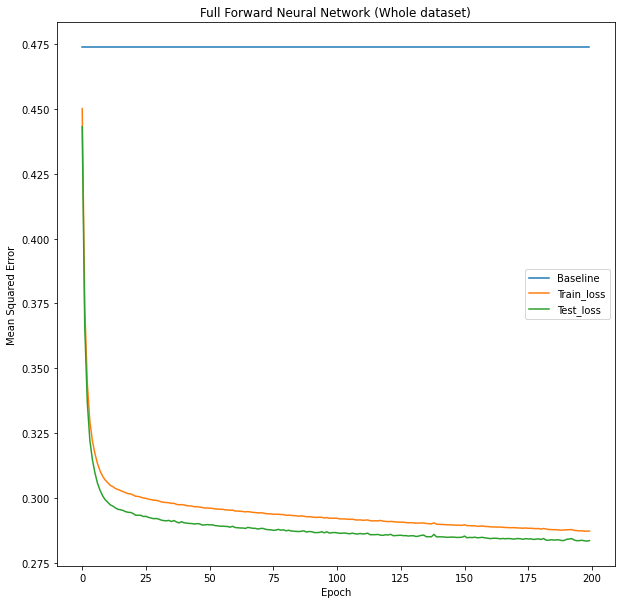

In [59]:
if train_FFN is True:

  # Show results of the loss function whole

  fig = plt.figure(figsize = (10,10))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [np.mean(losses_train) for i in range(len(train_losses_whole))]

  ax.plot(baseline, label='Baseline')
  ax.plot([np.mean(i) for i in train_losses_whole], label= 'Train_loss')
  ax.plot([np.mean(i) for i in test_losses_whole], label= 'Test_loss')
  ax.set_title("Full Forward Neural Network (Whole dataset)")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [60]:
results = torch.Tensor(1, 30, 18).to(device)
with torch.no_grad():
  trained_model_FFN_whole.train()
  count = 0
  for i in tqdm(training_data_seq):
    batch_result = torch.Tensor(1, 18).to(device)
    new = i[0].unsqueeze(0)

    for j in range(30):
      output = trained_model_FFN_whole(new)
      new = output
      if j == 0:
        batch_result = output
      else:
        batch_result = torch.cat((batch_result, output), 0)

    if count == 0:
      results = batch_result.unsqueeze(0)
    else:
      results = torch.cat((results, batch_result.unsqueeze(0)), 0)
    
    count += 1


100%|██████████| 56970/56970 [12:15<00:00, 77.49it/s]


In [61]:
print(results.shape)
print(training_target_seq.shape)


torch.Size([56970, 30, 18])
torch.Size([56970, 30, 18])


In [62]:
criterion = nn.MSELoss()

losses_train = []

for i in range(len(results)):
  output = results[i]
  target = training_target_seq[i]
  loss = criterion(output, target)
  losses_train.append(loss.item())

print("Training set")
print("Mean Loss of FFN baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of FFN baselinemodel: ", np.std(losses_train))
print('\n')

base_line_loss = np.mean(losses_train)

Training set
Mean Loss of FFN baselinemodel:  0.5681451591547485
Standard deviation Loss of FFN baselinemodel:  0.33429944602130834




# Conclusions FFN

Training this small, easy FFN have an improvement to the base model in the case that we don't take a sequence of samples but we compare each sample individually.

# Transformer Model settings

Now, we define a class with the transformer model that we are going to use:

Using the already written pytorch library for Transformers:

1) torch.nn.TransformerEncoderLayer (https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

*   d_model –> the number of expected features in the input (required).
*   nhead –> the number of heads in the multiheadattention models (required).
*   dropout –> the dropout value (default=0.1).
*   activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. (default: relu)
*   layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
*   batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). (default: False)
*   norm_first –> if True, layer norm is done prior to attention and feedforward operations, respectivaly. Otherwise it’s done after. (default: False (after))

2) torch.nn.TransformerDecoderLayer

* d_model –> the number of expected features in the input (required).
* nhead –> the number of heads in the multiheadattention models (required).
* dim_feedforward –> the dimension of the feedforward network model (default=2048).
* dropout –> the dropout value (default=0.1).
* activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu
* layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
* batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). Default: False.
* norm_first –> if True, layer norm is done prior to self attention, multihead attention and feedforward operations, respectivaly. Otherwise it’s done after. Default: False (after).

3) torch.nn.TransformerEncoder

* encoder_layer –> an instance of the TransformerEncoderLayer() class (required).
* num_layers –> the number of sub-encoder-layers in the encoder (required).
* norm –> the layer normalization component (optional).


4) torch.nn.TransformerDecoder

* decoder_layer – an instance of the TransformerDecoderLayer() class (required).
* num_layers – the number of sub-decoder-layers in the decoder (required).
* norm – the layer normalization component (optional).


In [117]:
def positional_encoding(seq_len: int, dim_model: int, device):

    position_encoding = torch.zeros(seq_len, dim_model)
    for pos in range(seq_len):
      for i in range(0, int(dim_model / 2)):
        position_encoding[pos, 2 * i] = math.sin(pos / (10000 ** ((2 * i)/dim_model)))
        position_encoding[pos, (2 * i) + 1] = math.cos(pos / (10000 ** ((2 * i)/dim_model)))

    return position_encoding.to(device)


class Transformer(nn.Module):
    def __init__(self, feature_size, output_size, num_encoder_layers, num_heads, num_decoder_layers, device, dim_feedforward: int=2048, dropout: float =0.1, batch_first: bool = False):
        super(Transformer, self).__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        decoder_layer = nn.TransformerDecoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers= num_decoder_layers)

        self.output_size = output_size
        self.device = device

    def generate_square_mask(self, dim):
        return torch.triu(torch.ones(dim, dim) * float('-inf'), diagonal=1).to(self.device)
        
    def forward (self, enc_input, dec_input):
        
        mask = self.generate_square_mask(len(enc_input))

        src_pos_enc = enc_input + positional_encoding(seq_len= enc_input.shape[1], dim_model= enc_input.shape[2], device= self.device)
        src_pos_dec = dec_input + positional_encoding(seq_len= dec_input.shape[1], dim_model= dec_input.shape[2], device= self.device)

        output = self.encoder (src=src_pos_enc, mask=None)
        output = self.decoder (tgt= src_pos_dec, memory= output, tgt_mask=mask, memory_mask=None)
        
        return output

We should define an optimizer too.
For this, we use the pytorch library:

* SGD –> Stochastic gradient descent.

1) torch.optim.SDG (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

* params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
* lr (float) – learning rate
* momentum (float, optional) – momentum factor (default: 0)
* weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)
* dampening (float, optional) – dampening for momentum (default: 0)
* nesterov (bool, optional) – enables Nesterov momentum (default: False)

In [112]:
def training_transformer(model, optimizer, criterion, train_loader, test_loader, n_epochs):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      target = i[1]

      net_out = model.forward(input, target)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):
        input = i[0]
        target = i[1]

        net_out = model.forward(input, target)
        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(test_loader):
        input = i[0]
        target = i[1]

        net_out = model.forward(input, target)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

In [118]:
# Initialize Transformer Model and Optimizer

continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=False)

n_epochs = 10

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01)
criterion = nn.MSELoss()

print('Setup optimizer Ok')


train_transformer = True

if train_transformer is True:
  trained_model_transformer, train_losses, test_losses = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs)

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 10
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.01it/s]



Test with training set


100%|██████████| 1899/1899 [00:17<00:00, 110.29it/s]



Current Mean loss Train Set:  0.2271704869545906

Test with test set


100%|██████████| 211/211 [00:01<00:00, 110.32it/s]



Current Mean loss Test Set:  0.2281173047437487


Epoch: 2 of 10
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.57it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 112.22it/s]



Current Mean loss Train Set:  0.19934470334010354

Test with test set


100%|██████████| 211/211 [00:01<00:00, 110.84it/s]



Current Mean loss Test Set:  0.19989948271292646


Epoch: 3 of 10
Training...


  7%|▋         | 136/1899 [00:03<00:43, 40.37it/s]


KeyboardInterrupt: ignored

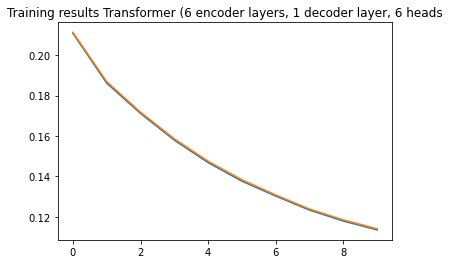

In [116]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure()

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [base_line_loss for i in range(len(train_losses))]
  ax.plot(baseline)


  ax.plot([np.mean(i) for i in train_losses])
  ax.plot([np.mean(i) for i in test_losses])
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads")
  fig.canvas.draw()